# 02. DCGAN with Face

http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html (Large-scale CelebFaces Attributes) : 178 * 218

http://vis-www.cs.umass.edu/lfw/  (Labeled Faces in the Wild)

In [1]:
import torch
import torch.nn as nn
import torch.nn.init as init
import torch.optim as optim
import torch.utils.data as data

import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms

import numpy as np
import time

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# GPU check
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [25]:
torch.manual_seed(7)

## Load Data

In [4]:
image_size = 64
batch_size = 128
latent_size = 100

In [5]:
train_transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.CenterCrop(image_size),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

train_data = datasets.ImageFolder('data/celeba/', train_transform)

train_loader = data.DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=0)

In [6]:
print(len(train_data))

202599


In [7]:
def imshow(img, title):
    npimg = img.numpy()
    fig = plt.figure(figsize = (10, 20))
    plt.imshow(np.transpose(npimg,(1,2,0)))
    plt.title(title)
    plt.show()

torch.Size([128, 3, 64, 64])


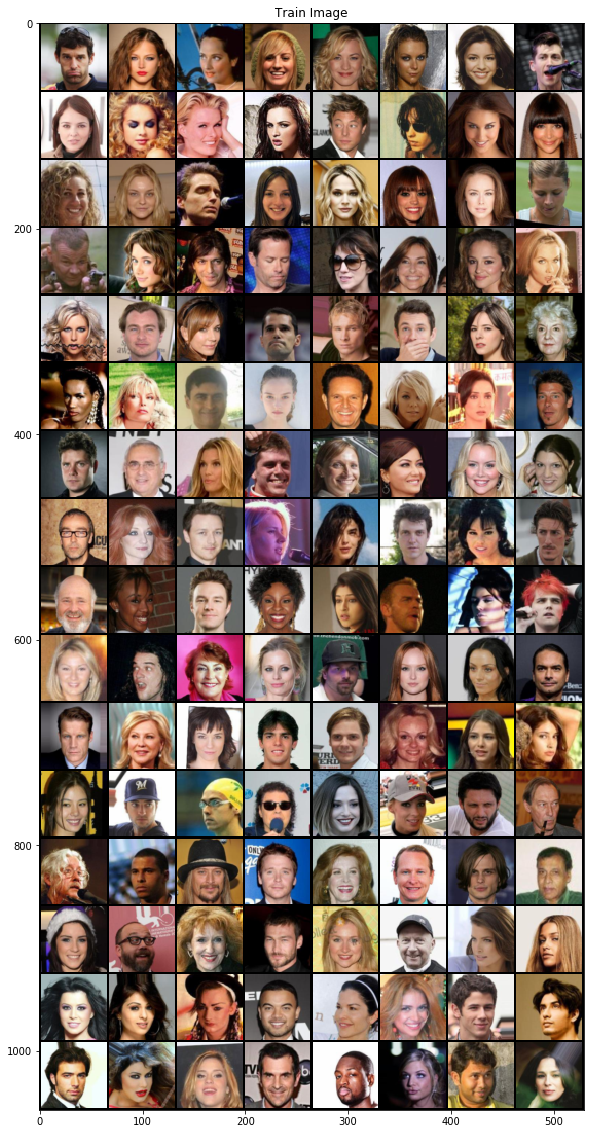

In [8]:
images, labels = iter(train_loader).next()
print(images.size())
imshow(torchvision.utils.make_grid(images, normalize=True), "Train Image")

## Define Model

In [9]:
# N: input, F: filter, S: stride, P: padding
def c_conv(N, F, S=1, P=0):
    return int((N+2*P-F)/S+1)

# Transposed convolution
def t_conv(N, F, S=1, P=0):
    return int(S*(N-1)+F-2*P)

In [10]:
# Discriminator
c0 = image_size
c1 = c_conv(c0, 4, 2, 1)
c2 = c_conv(c1, 4, 2, 1)
c3 = c_conv(c2, 4, 2, 1)
c4 = c_conv(c3, 4, 2, 1)
c5 = c_conv(c4, 4, 1, 0)

print(c0, c1, c2, c3, c4, c5)

# Generator
t0 = c5
t1 = t_conv(t0, 4, 1, 0)
t2 = t_conv(t1, 4, 2, 1)
t3 = t_conv(t2, 4, 2, 1)
t4 = t_conv(t3, 4, 2, 1)
t5 = t_conv(t4, 4, 2, 1)

print(t0, t1, t2, t3, t4, t5)

64 32 16 8 4 1
1 4 8 16 32 64


In [11]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        self.discriminator = nn.Sequential(
            nn.Conv2d(3, 64, 4, stride=2, padding=1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(64, 128, 4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(128, 256, 4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(256, 512, 4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(512, 1, 4, stride=1, padding=0, bias=False),
            nn.Sigmoid()
        )
        
        # Weight Initialization
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.normal_(m.weight.data, 0.0, 0.02)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.normal_(m.weight.data, 1.0, 0.02)
                m.bias.data.fill_(0)
                
    def forward(self, x):
        out = self.discriminator(x)
        out = out.view(-1, 1)
        return out

In [12]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        
        self.generator = nn.Sequential(
            nn.ConvTranspose2d(latent_size, 512, 4, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            
            nn.ConvTranspose2d(512, 256, 4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(256, 128, 4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            
            nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            
            nn.ConvTranspose2d(64, 3, 4, stride=2, padding=1, bias=False),
            nn.Tanh()
        )
        
        # Weight Initialization
        for m in self.modules():
            if isinstance(m, nn.ConvTranspose2d):
                nn.init.normal_(m.weight.data, 0.0, 0.02)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.normal_(m.weight.data, 1.0, 0.02)
                m.bias.data.fill_(0)

    def forward(self, x):
        x = x.view(-1, latent_size, 1, 1)
        out = self.generator(x)
        return out

In [13]:
D = Discriminator().to(device)
G = Generator().to(device)

z = torch.randn(batch_size, latent_size).to(device)
print(G(z).shape)

torch.Size([128, 3, 64, 64])


In [14]:
def gan_loss(x, target_is_real):
    
    loss = nn.BCELoss()
    
    if target_is_real : 
        target_tensor = torch.ones(x.size()[0], 1)
    else :
        target_tensor = torch.zeros(x.size()[0], 1)       
        
    return loss(x, target_tensor.to(device))

In [15]:
G_optimizer = optim.Adam(G.parameters(), lr=0.0002, betas=(0.5, 0.999))
D_optimizer = optim.Adam(D.parameters(), lr=0.0002, betas=(0.5, 0.999))

## Training

In [16]:
num_epochs = 40

for epoch in range(num_epochs):
    
    total_batch = len(train_data) // batch_size
    
    for i, (images, labels) in enumerate(train_loader):
        
        images = images.to(device)
        
        #-----------------------------------
        # Train D
        
        prob_real = D(images)
        
        D_loss_real = gan_loss(prob_real, True)

        z = torch.randn(batch_size, latent_size).to(device)
        fake_images = G(z)
        
        prob_fake = D(fake_images)
        D_loss_fake = gan_loss(prob_fake, False)
        
        D_loss = (D_loss_real + D_loss_fake) / 2
        
        D.zero_grad()
        D_loss.backward()
        D_optimizer.step()
        
        #-----------------------------------
        # Train G
        
        z = torch.randn(batch_size, latent_size).to(device)
        fake_images = G(z)
        
        prob_fake = D(fake_images)
        G_loss = gan_loss(prob_fake, True)
        
        G.zero_grad()
        G_loss.backward()
        G_optimizer.step()        

        #-----------------------------------
        if (i+1) == total_batch:
            print('Epoch [%d/%d], lter [%d/%d], D_Loss: %.4f, G_Loss: %.4f'
                 %(epoch+1, num_epochs, i+1, total_batch, D_loss.item(), G_loss.item()))
    
    if (epoch + 1) % 20 == 0:
        torch.save(G.state_dict(), 'saved_models/dcgan_celeb_G_{:03d}.pkl'.format(epoch+1))
        torch.save(D.state_dict(), 'saved_models/dcgan_celeb_D_{:03d}.pkl'.format(epoch+1))

Epoch [1/40], lter [1582/1582], D_Loss: 0.4550, G_Loss: 7.2882
Epoch [2/40], lter [1582/1582], D_Loss: 0.2634, G_Loss: 2.4912
Epoch [3/40], lter [1582/1582], D_Loss: 0.3648, G_Loss: 2.5832
Epoch [4/40], lter [1582/1582], D_Loss: 0.2787, G_Loss: 2.4516
Epoch [5/40], lter [1582/1582], D_Loss: 0.2873, G_Loss: 1.5772
Epoch [6/40], lter [1582/1582], D_Loss: 0.2631, G_Loss: 2.0795
Epoch [7/40], lter [1582/1582], D_Loss: 0.3098, G_Loss: 1.7391
Epoch [8/40], lter [1582/1582], D_Loss: 0.2825, G_Loss: 1.5012
Epoch [9/40], lter [1582/1582], D_Loss: 0.1929, G_Loss: 2.3585
Epoch [10/40], lter [1582/1582], D_Loss: 0.2409, G_Loss: 2.5643
Epoch [11/40], lter [1582/1582], D_Loss: 0.1892, G_Loss: 4.1067
Epoch [12/40], lter [1582/1582], D_Loss: 0.1196, G_Loss: 3.4986
Epoch [13/40], lter [1582/1582], D_Loss: 0.1057, G_Loss: 3.5160
Epoch [14/40], lter [1582/1582], D_Loss: 0.2126, G_Loss: 4.8786
Epoch [15/40], lter [1582/1582], D_Loss: 0.1407, G_Loss: 2.9413
Epoch [16/40], lter [1582/1582], D_Loss: 0.5475, 

## Generate Image

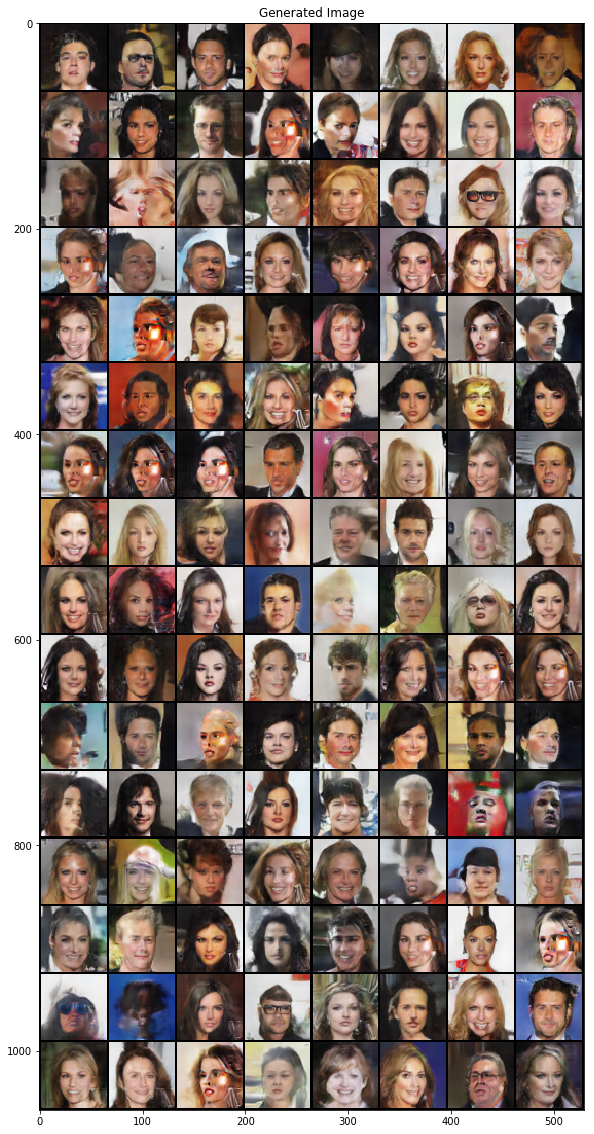

In [26]:
G.load_state_dict(torch.load('saved_models/dcgan_celeb_G_040.pkl'))
z = torch.randn(batch_size, latent_size).to(device)   
images = G(z)
imshow(torchvision.utils.make_grid(images.data.cpu(), normalize=True), "Generated Image")

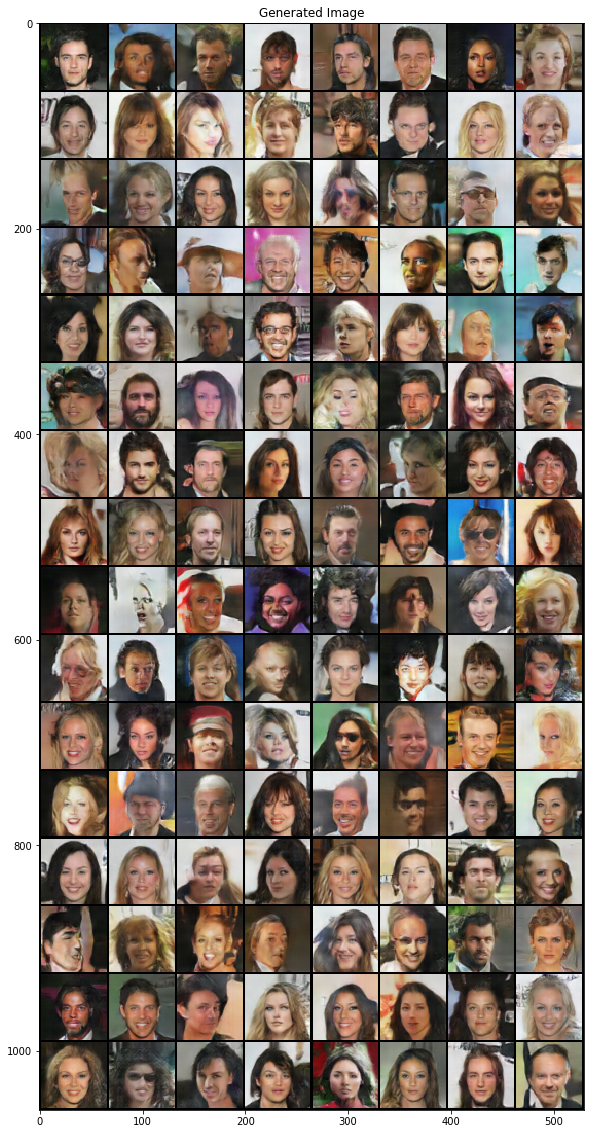

In [29]:
G.load_state_dict(torch.load('saved_models/dcgan_celeb_G_020.pkl'))
z = torch.randn(batch_size, latent_size).to(device)   
images = G(z)
imshow(torchvision.utils.make_grid(images.data.cpu(), normalize=True), "Generated Image")

In [41]:
G.load_state_dict(torch.load('saved_models/dcgan_celeb_G_040.pkl'))

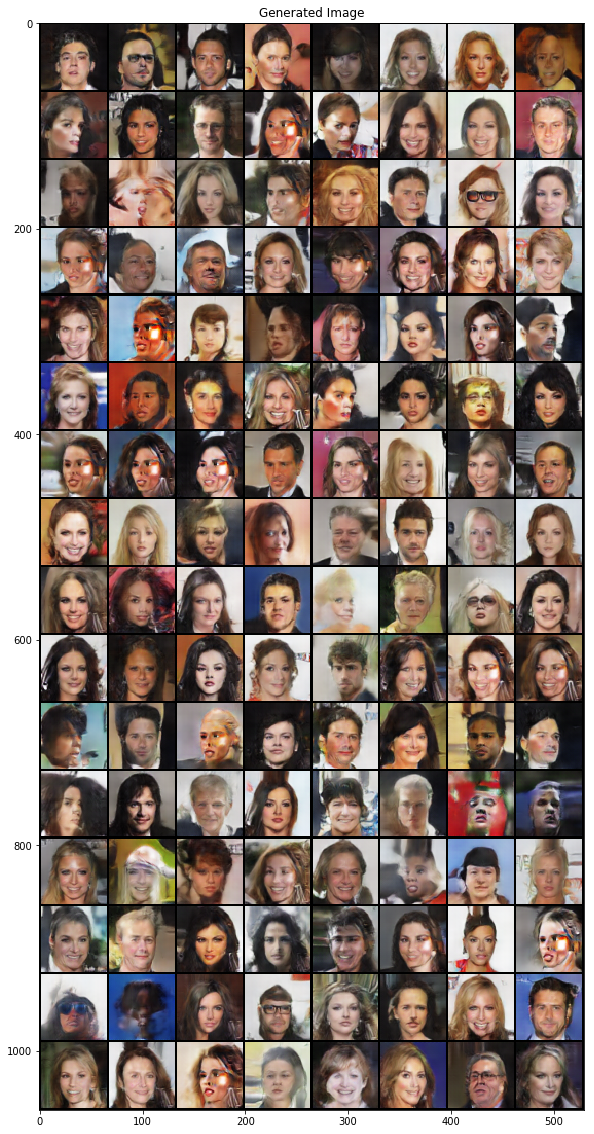

In [75]:
torch.manual_seed(7)
z = torch.randn(128, latent_size).to(device)
images = G(z)
imshow(torchvision.utils.make_grid(images.data.cpu(), normalize=True), "Generated Image")

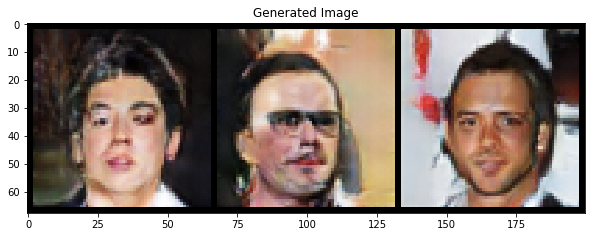

In [81]:
torch.manual_seed(7)
z01 = torch.randn(batch_size, latent_size).to(device)[:3]
images = G(z01)
imshow(torchvision.utils.make_grid(images.data.cpu(), normalize=True), "Generated Image")

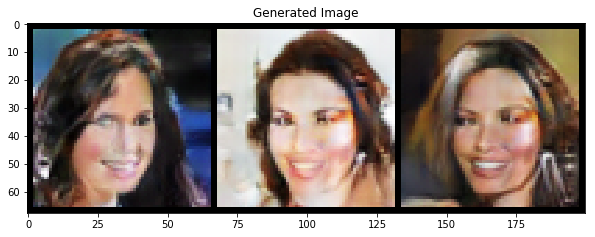

In [82]:
torch.manual_seed(7)
z02 = torch.randn(batch_size, latent_size).to(device)[77:80]
images = G(z02)
imshow(torchvision.utils.make_grid(images.data.cpu(), normalize=True), "Generated Image")

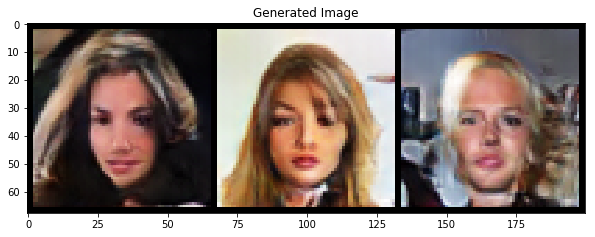

In [83]:
torch.manual_seed(7)
z_temp = torch.randn(batch_size, latent_size).to(device)
z1 = z_temp[18]
z2 = z_temp[57]
z3 = z_temp[62]
z03 = torch.stack([z1, z2, z3])
images = G(z03)
imshow(torchvision.utils.make_grid(images.data.cpu(), normalize=True), "Generated Image")

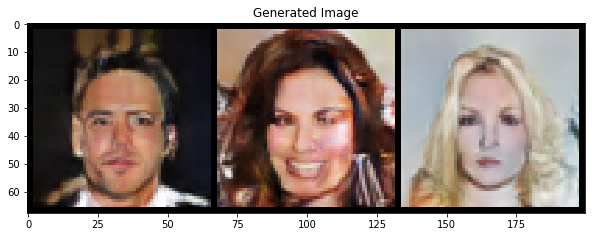

In [91]:
zmean_01 = torch.mean(z01, dim=0)
zmean_02 = torch.mean(z02, dim=0)
zmean_03 = torch.mean(z03, dim=0)
zmean_stack = torch.stack([zmean_01, zmean_02, zmean_03])
images = G(zmean_stack)
imshow(torchvision.utils.make_grid(images.data.cpu(), normalize=True), "Generated Image")

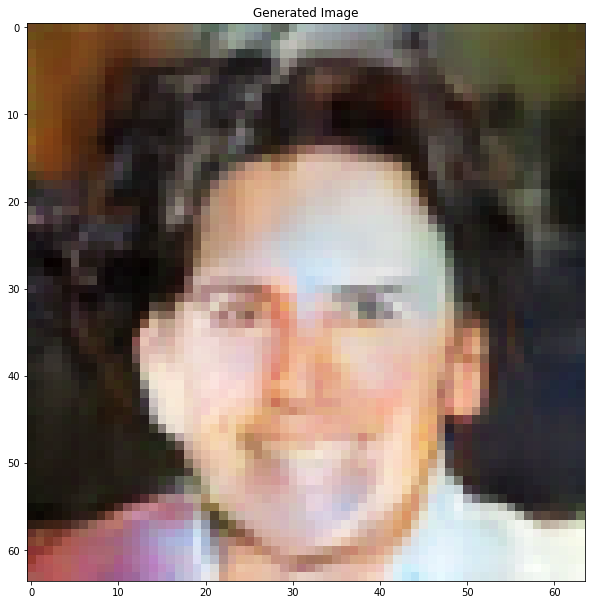

In [95]:
z_result = zmean_01 + zmean_02 - zmean_03
images = G(z_result)
imshow(torchvision.utils.make_grid(images.data.cpu(), normalize=True), "Generated Image")